<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Segmentation/blob/main/Fine_tuning_Segment_Anything_Model_(SAM)_using_Keras_and_%F0%9F%A4%97_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**

Large language models (LLMs) allow users to apply them to various tasks through "prompting," such as predicting sentiment from a sentence. For visual recognition tasks, visual prompts like bounding boxes can be used to guide foundation vision models.

The Segment Anything Model (SAM) by Meta extends prompting to visual tasks, enabling zero-shot segmentation with prompts such as points, text, boxes, or masks. SAM supports various segmentation tasks, including semantic segmentation and edge detection, through prompting.

This example will demonstrate using the SAM model from 🤗 Transformers for inference and fine-tuning.

**Reference:**
- [Segment Anything Paper](https://doi.org/10.48550/arXiv.2304.02643)
- [Keras Example](https://keras.io/examples/vision/sam/)

## **SAM (Segment Anything Model)**

SAM (Segment Anything Model) has an image encoder to compute image embeddings and a prompt encoder for processing different prompts (points, bounding boxes, masks). The embeddings from these encoders are combined and fed into a mask decoder, which predicts the segmentation mask. Pre-trained to handle ambiguity, SAM can predict multiple masks for a single prompt. For more details, refer to the SAM paper and blog post.

![](https://i.imgur.com/QQ9Ts5T.png)

## Installation

In [1]:
!!pip install -q git+https://github.com/huggingface/transformers

['  Installing build dependencies ... \x1b[?25l\x1b[?25hdone',
 '  Getting requirements to build wheel ... \x1b[?25l\x1b[?25hdone',
 '  Preparing metadata (pyproject.toml) ... \x1b[?25l\x1b[?25hdone']

In [2]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import requests
import glob
import os

## Running Inference with SAM

There are three checkpoints for SAM:
- `sam-vit-base`
- `sam-vit-large`
- `sam-vit-huge`

To run inference, load the `sam-vit-base` checkpoint in `TFSamModel` and use `SamProcessor` for the associated checkpoint.

In [3]:
model = TFSamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


## Utility functions for visualization

In [4]:
np_config.enable_numpy_behavior()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

def show_masks_on_image(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    np_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, np_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f'Mask {i+1}, Score: {score.numpy().item():.3f}')
        axes[i].axis('off')
    plt.show()

## Loading an image of a car and segment it.

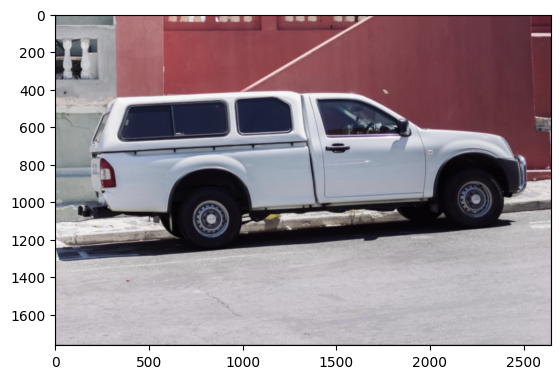

In [5]:
img_url = 'https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plt.imshow(raw_image)
plt.show()

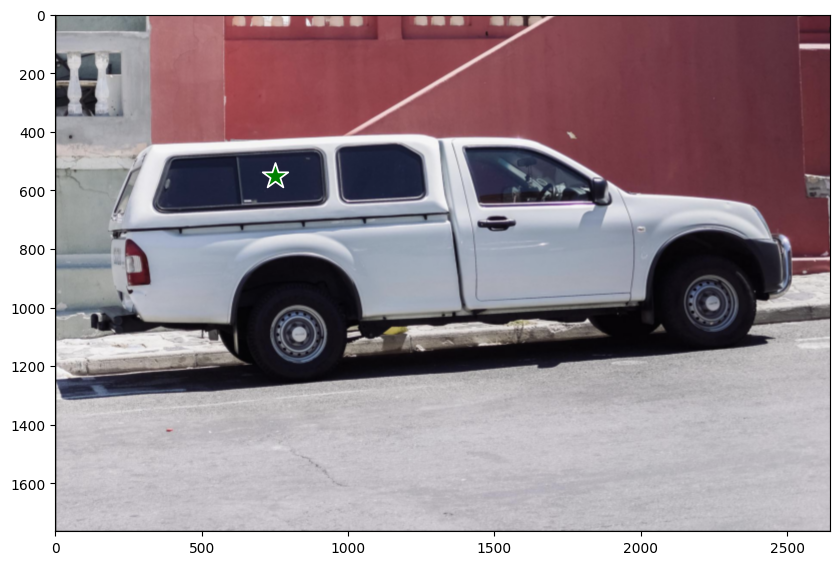

In [6]:
## Define a set of points we will use as the prompt
input_points = [[[750, 550]]]

# Visualize a single point
show_points_on_image(raw_image, input_points[0])

In [7]:
## Preprocess the input image for Segmentation
inputs = processor(raw_image, input_points=input_points, return_tensors="tf")

# Predict For segmentation with the prompt
outputs = model(**inputs)

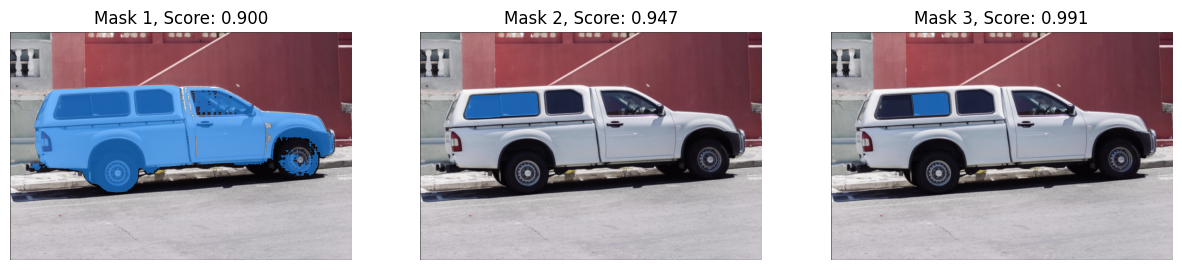

In [8]:
## Post Process the mask and visualize them with IoU scores
'''
Ourput has 2 attributes:
  - outputs.pred_masks: denotes the predicted mask
  - outputs.iou_scores: denotes the IoU scores for each mask
'''
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"],
    return_tensors='tf'
)

show_masks_on_image(raw_image, masks, outputs.iou_scores)

## Fine-tuning with breast cancer scans dataset

### Data preparation

In [9]:
# Load the data
remote_path = 'https://hf.co/datasets/sayakpaul/sample-datasets/resolve/main/breast-cancer-dataset.tar.gz'
dataset_path = keras.utils.get_file(
    fname='breast-cancer-dataset.tar.gz',
    origin=remote_path,
    untar=True
)

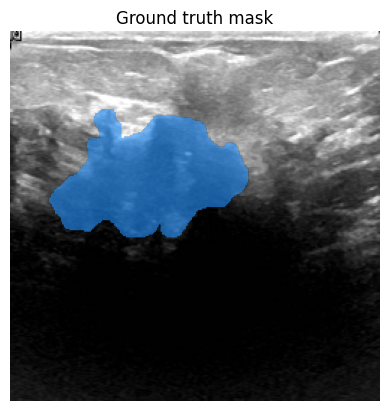

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([256, 256], dtype=int32)>

In [10]:
# Visualize a sample from the dataset
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Load all image and label paths
image_paths = sorted(glob.glob(os.path.join(dataset_path, 'images/*.png')))
label_paths = sorted(glob.glob(os.path.join(dataset_path, 'labels/*.png')))

# Load the image and label
idx = 15
image = Image.open(image_paths[idx])
label = Image.open(label_paths[idx])
image = np.array(image)
ground_truth_seg = np.array(label)

# Display image
fig, axes = plt.subplots()
axes.imshow(image)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f'Ground truth mask')
axes.axis('off')
plt.show()

tf.shape(ground_truth_seg)

### Preparing tf.data.Dataset

In [11]:
## Generator class for processing the images and the masks for SAM fine-tuning
class Generator:
    def __init__(self, dataset_path, processor):
        self.dataset_path = dataset_path
        self.image_paths = sorted(glob.glob(os.path.join(dataset_path, 'images/*.png')))
        self.label_paths = sorted(glob.glob(os.path.join(dataset_path, 'labels/*.png')))
        self.processor = processor

    def __call__(self):
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image = np.array(Image.open(image_path))
            ground_truth_mask = np.array(Image.open(label_path))

            # Get bounding box
            prompt = self.get_bounding_box(ground_truth_mask)

            # Prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors='np')

            # Remeve batch dimension which the processor adds by default
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # Add ground truth segmentation
            inputs['ground_truth_mask'] = ground_truth_mask

            yield inputs

    def get_bounding_box(self, ground_truth_map):
        # Get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        return bbox

In [12]:
## Prepare the tf.data.Dataset from our training set

# Define the output signature of the generator class
output_signature = {
    'pixel_values': tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    'original_sizes': tf.TensorSpec(shape=(None,), dtype=tf.int64),
    'reshaped_input_sizes': tf.TensorSpec(shape=(None,), dtype=tf.int64),
    'input_boxes': tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    'ground_truth_mask': tf.TensorSpec(shape=(None, None), dtype=tf.int32)
}

# Prepare the dataset object
train_dataset_gen = Generator(dataset_path, processor)
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen,
    output_signature=output_signature
)


In [13]:
# Configure the dataset for performance
auto = tf.data.AUTOTUNE
batch_size = 2
shuffle_buffer = 4

train_ds = (
    train_ds.cache()
    .shuffle(shuffle_buffer)
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)

In [14]:
# Inspect the shapes of elements in a single batch
sample = next(iter(train_ds))
for k in sample:
    print(k, sample[k].shape, sample[k].dtype, isinstance(sample[k], tf.Tensor))

pixel_values (2, 3, 1024, 1024) <dtype: 'float32'> True
original_sizes (2, 2) <dtype: 'int64'> True
reshaped_input_sizes (2, 2) <dtype: 'int64'> True
input_boxes (2, 1, 4) <dtype: 'float64'> True
ground_truth_mask (2, 256, 256) <dtype: 'int32'> True


### Training

In [15]:
## Function for DICE loss based on MONAI DICE loss
def dice_loss(y_true, y_pred, smooth=1e-5):
    y_pred = tf.sigmoid(y_pred)
    reduce_axis = list(range(2, len(y_pred.shape)))
    if batch_size > 1:
        reduce_axis = [0] + reduce_axis # reducing spacial dimensions and batch
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)
    y_true_sq = tf.math.pow(y_true, 2)
    y_pred_sq = tf.math.pow(y_pred, 2)

    ground_o = tf.reduce_sum(y_true_sq, axis=reduce_axis)
    pred_o = tf.reduce_sum(y_pred_sq, axis=reduce_axis)
    denominator = ground_o + pred_o

    # Calculate DICE Co-efficient
    loss = 1.0 - (2.0 * intersection + 1e-5) / (denominator + 1e-5)
    loss = tf.reduce_mean(loss)

    return loss

### Fine-tuning SAM

In [18]:
# Initialize SAM Model and Optimizer
sam = TFSamModel.from_pretrained("facebook/sam-vit-base")
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

for layer in sam.layers:
    if layer.name in ['vision_encoder', 'prompt_encoder']:
        layer.trainable = False

@ tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # Pass inputs to SAM model
        outputs = sam(
            pixel_values=inputs['pixel_values'],
            input_boxes=inputs['input_boxes'],
            multimask_output=False,
            training=True
        )

        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs['ground_truth_mask'], tf.float32)

        # Calculate loss over predicted and ground truth masks
        loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)

        # Update trainable variables
        trainable_vars = sam.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(gradients, trainable_vars))

        return loss

All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


In [20]:
# Run the training
for epoch in range(10):
    for inputs in train_ds:
        loss = train_step(inputs)
    print(f"Epoch {epoch + 1}: Loss = {loss}")

Epoch 1: Loss = 0.06483888626098633
Epoch 2: Loss = 0.045973002910614014
Epoch 3: Loss = 0.09487557411193848
Epoch 4: Loss = 0.05081748962402344
Epoch 5: Loss = 0.055504679679870605
Epoch 6: Loss = 0.08214205503463745
Epoch 7: Loss = 0.05340546369552612
Epoch 8: Loss = 0.05614274740219116
Epoch 9: Loss = 0.08196228742599487
Epoch 10: Loss = 0.06186944246292114


### Serialize the model and push it to Hugging Face Hub

In [22]:
# import os
# os.environ["HF_TOKEN"] = "hf_"  # actual token

In [ ]:
sam.push_to_hub('Ashaduzzaman/sam-finetuned-breast-cancer-segmentation')
processor.push_to_hub('Ashaduzzaman/sam-finetuned-breast-cancer-segmentation')

### Infer with the Model and Visualize the results

In [26]:
# Load another image for the inference
idx = 100
raw_image_inference = Image.open(image_paths[idx])

# Process the image and infer
preprocessed_img = processor(raw_image_inference)
outputs = sam(preprocessed_img)

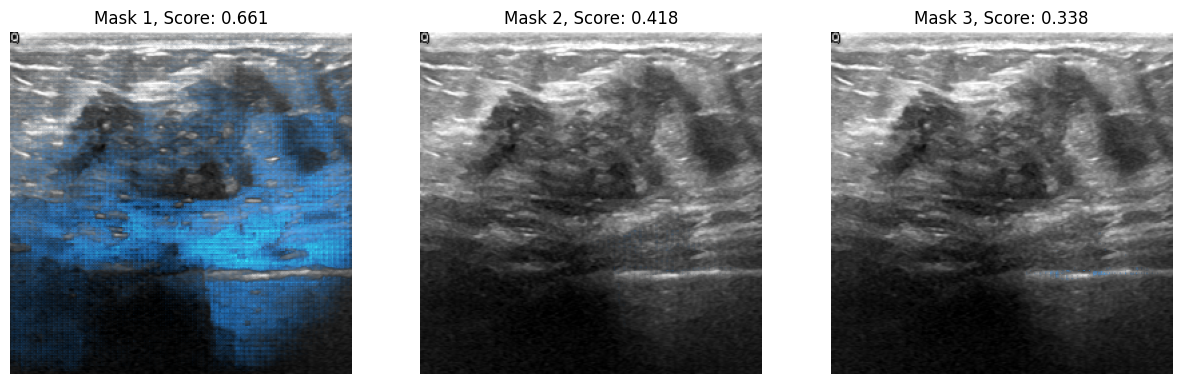

In [27]:
# Visualize the results
infer_masks = outputs['pred_masks']
iou_scores = outputs['iou_scores']

show_masks_on_image(raw_image_inference, masks=infer_masks, scores=iou_scores)